<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/proto-gradients/sequences/P2C1_CurveFitting/P2C1_Sequence2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **2.1.2: Curve Fitting Through the Delta Rule**
In the previous seqeunce we saw how a simple binary discrimination task could be solved by training a simple 'neural circuit' model using scalar reward feedback. Scalar reward feedback was sufficient for this simple problem, but as we will see in this sequence, as the discrimination task becomes more challenging, learning becomes problematically slow when driven solely by reward. To effectively train our neural circuit model we will need to update our parameters more efficiently. With perturbation, we were using a measure and see approach. In this sequence we will instead leverage our knowledge of the structure of the circuit to make more effient updates, specifically targeting those parameters of the model that were causally implicated in the output for adaption. Note that these updates will still be driven purely by a reward signal, i.e. the organism will still have no clear indication about what the correct action was when it fails.

### Objective: See how reward driven perturbation is problematically slow on a more complicated problem. Solve this slightly more complicated problem using the "Delta Rule". See how how using knowledge of the structure of the model let's us make far more effcient parameter updates. Connect these methods with physiological neural plasticity mechanisms.

In this sequence we will:

* Introduce a 10-category classification tasks, i.e. a task where stimuli indicate which specific action, from a set of 10 possible actions, should be executed to obtain a reward.

* See how the simple 'neural circuit' model which 'learned' to solve a binary discrimination problems based on reward feedback, is incapable of solving this more complext problem in a reasonable amount of time.

* See how a slightly adapted 'neural circuit' model which uses knowledge of the model structure for efficeint parameter updates can solve this more complex problem in a reasonable amount of time.

* Relate these structure based updates to various neural plasticity mechanisms.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S1"

Best feature is 21
Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.2.1: Learning to Do 10 Different Right Things

In our the last sequence we motivated a binary classification problem with the image of a lurking predator that must choose between striking and not striking based on sensory input. We focused on the case where the behavioural map from sensory input to action was to be entirely 'learned' by the organism, using feedback signals from the environment. In this sequence we will work with an almost identical problem, except that now instead of two possible actions, strike and no-strike, we deal with 10 possible distinct actions. Different sensory input patterns will indicate which of the 10 possible distinct actions yeild a reward. We can imagine these highly abstracted actions corresponding to different prey capture and/or predator avoidance behaviours. The organism must match the correct behaviour to the correct stimuli to eat and avoid being eaten. Before we build a highly abstracted model of a neural circuit to solve this problem, let's see if your neural network is up to the task. Given a sensory input pattern, determine which of ten actions to chose. Try to maximize your average score and see how well you can perform.

In [2]:
# @markdown **Run this cell** to try out the 10-action discrimination task.

class InteractiveMNISTCritter():
  def __init__(self,
               features=Xs,
               labels=y,
               num_actions=2,
               feedback_type='reward_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    self.num_actions = num_actions
    # Ensure num_actions matches the number of unique labels
    unique_labels = len(np.unique(self.labels))
    if self.num_actions != unique_labels:
        raise ValueError(f"The number of actions ({self.num_actions}) must equal the number of unique labels ({unique_labels}).")
    # features is num_data_points x 64 (reshape to 8x8 for display, each cell 0-16)
    # labels is num_data_points x 1 (values 0-9 or 0/1 depending)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    # initialize game state
    self.current_index = 0
    self.score = 0
    self.best_possible_score = 0
    self.successful_actions = np.zeros(self.num_actions)
    self.failed_actions = np.zeros(self.num_actions)
    # Initialize widgets
    self.action_buttons = [] # List to store buttons
    for action_idx in range(self.num_actions):
        # Create a button for each action
        button = widgets.Button(description=f'Action {action_idx}')
        button.on_click(self.on_button_click)
        self.action_buttons.append(button)
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.show_next_image()

    # Arrange widgets in a layout

    button_split_index = (num_actions + 1) // 2  # This ensures the longer row is on top if odd number
    row1_buttons = widgets.HBox(self.action_buttons[:button_split_index])
    row2_buttons = widgets.HBox(self.action_buttons[button_split_index:])
    buttons_layout = widgets.VBox([row1_buttons, row2_buttons])
    board_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    self.ui = widgets.HBox([board_buttons, widgets.VBox([self.score_display,
                                                         self.feedback_display])])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]
    if len(image) == 64:
        image = image.reshape(8, 8)
    elif len(image) == 1:
      scalar_value = image.flatten()[0]
      # Initialize the 8x8 array with -6 (black)
      image = np.full((8, 8), -6.0)
      # Set the second ring to 6 (white)
      image[1:-1, 1:-1] = 6
      # Set the third (inner ring) back to -6 (black)
      image[2:-2, 2:-2] = -6
      # Assuming scalar_value is already in the range -6 to 6
      #print(scalar_value)
      image[3:-3, 3:-3] = scalar_value
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    # Display the image
    #print(image)
    self.fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.ax.set_xlim(-.5, 7.5)
    self.ax.set_ylim(-0.5, 7.5)
    self.ax.set_aspect('equal')
    self.ax.axis('off')
    self.ax.imshow(image, cmap='gray', vmin=-6, vmax=6)
    self.fig.canvas.draw_idle()  # Force redraw

  def on_button_click(self, button):
    # Disable buttons while processing
    for btn in self.action_buttons:
      btn.disabled = True
    # Access the button's description to know which button was clicked
    chosen_action = int(button.description.split(' ')[-1])
    correct_action = self.labels[self.current_index]
    if chosen_action == correct_action:
      self.score += 1
      self.successful_actions[chosen_action] += 1
    else:
      self.score -= 1
      self.failed_actions[chosen_action] += 1
    # Show text feedback
    was_correct = 'Correct' if chosen_action == correct_action else 'Incorrect'
    feedback = f'Your last choice: {chosen_action}\n{was_correct}'
    with self.feedback_display:
      clear_output(wait=True)
      print(feedback)
    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Total Score: {self.score}')
      print(f'Number of Trials: {self.current_index + 1}')
      print(f'Successful Actions: {self.successful_actions}')
      print(f'Failed Actions: {self.failed_actions}')
      print(f'Average Score Per Trial: {average_score:.2f}')
    # Prepare the next image
    self.current_index += 1
    self.show_next_image()

    # Re-enable buttons
    for btn in self.action_buttons:
      btn.disabled = False


scramble_10 = InteractiveMNISTCritter(features=Xs, labels=y, num_actions=10)
display(scramble_10.fig.canvas)
clear_output()
display(scramble_10.ui)

For us at least, this was basically impossible. Maybe though, we will be able to come up an algorithm that can learn these associations. As before the dataset that underlies this strike-no-strike decision problem is sourced from the UCI Machine Learning Repository, (Alpaydin,E. and Kaynak,C. 1998. https://doi.org/10.24432/C50P49). Let's take a quick look at the data before we start coming up with a simple machine learning algorithm to correctly distinguish between the strike and no-strike cases.

In [3]:
# What is the shape and type of the data we have to work with
print(f'features data type: {Xs.dtype}')
print(f'features shape: {Xs.shape}')
print(f'labels data type: {y.dtype}')
print(f'labels shape: {y.shape}')

features data type: float64
features shape: (5620, 64)
labels data type: int64
labels shape: (5620, 1)


In [4]:
# what do the labels look like, what is their range
print(y[:10])
print(f'max label: {np.max(y)}')
print(f'min label: {np.min(y)}')

[[0]
 [0]
 [7]
 [4]
 [6]
 [2]
 [5]
 [5]
 [0]
 [8]]
max label: 9
min label: 0


***Recall:*** In a Supervised Learning context what we have been thinking of as the inputs to a sensory-behaviour circuit are called **features**. In a statistical/regression/experimental context these features or inputs are thought of as the independent variables or regressors. The 'correct' behavioural output is called the **label** or **target** in a supervised learning ML context, or the dependent variable in a statistical/regression/experimental context. Supervised Learning revolves around the concept of feature-label or $(\mathbf{x},\mathbf{y})$ pairs. The basic goal of Supervised Learning is to discover the rule or process that generates these pairs, or a good approximation of it, solely by examining examples. The set of examples that we have to learn the rule from is called the **training set**. A reminder that we will use the terms features and label when we want to emphasize the abstract algorithm and learning problem, and the terms sensory-input and target behaviour when we want to emphasize the embodied neural context of the problem.

In the game we setup above we used the labels to correspond to the numbered actions. Note that we only recieved feedback about whether or not we had chosen the correct action, and not about what the correct action should have been. So even though the labels in this data set determine which action is rewarding, learning is still only based on reward, the teaching signal does not indicate which action would have been correct when an incorrect action is chosen.

In [5]:
# what do the features look like, what is there range
print(Xs[:10])
print(f'max features: {np.max(Xs)}')
print(f'min features: {np.min(Xs)}')

[[-1.5   0.   -4.5  -5.25  3.    5.25 -3.75 -6.   -6.   -6.   -2.25 -0.75
   4.5  -1.5  -6.   -6.   -4.5  -6.   -6.   -6.   -6.   -6.   -0.75 -5.25
  -0.75  4.5  -3.75  0.75 -2.25 -1.5  -0.75  3.75 -6.   -5.25  5.25  0.
  -6.    1.5   3.   -0.75 -6.   -6.   -6.   -6.   -5.25 -6.    3.75  6.
  -6.   -6.   -2.25 -6.   -6.    2.25 -6.   -1.5   6.    6.   -6.   -6.
  -3.   -6.    0.75 -6.  ]
 [ 1.5   2.25 -6.   -6.    5.25  1.5  -6.   -6.   -6.   -6.    2.25  5.25
   6.    6.   -6.   -6.   -3.75 -6.   -5.25 -6.   -6.   -6.    3.   -6.
  -0.75  6.   -6.    0.    2.25  0.    2.25  3.   -6.   -6.    6.    0.
  -3.75 -2.25 -1.5   3.   -6.   -6.   -6.   -6.   -3.75 -6.    3.75  3.
  -6.   -6.    3.   -6.   -6.    4.5  -6.    1.5   6.    6.   -6.   -6.
  -0.75 -6.    5.25 -1.5 ]
 [ 0.75 -6.   -6.    3.75  3.   -3.    6.   -5.25 -6.   -6.   -6.   -6.
  -4.5   2.25 -6.   -6.   -6.   -6.    6.   -6.   -6.    6.    1.5  -6.
  -5.25  4.5  -3.    6.    3.    0.75 -4.5   6.   -6.    1.5   5.25  6.
  -6

In the visualization above a high 'feature value' corresponded to lighter colors in the center pixels and a lower feature value corresponded to darker feature values.

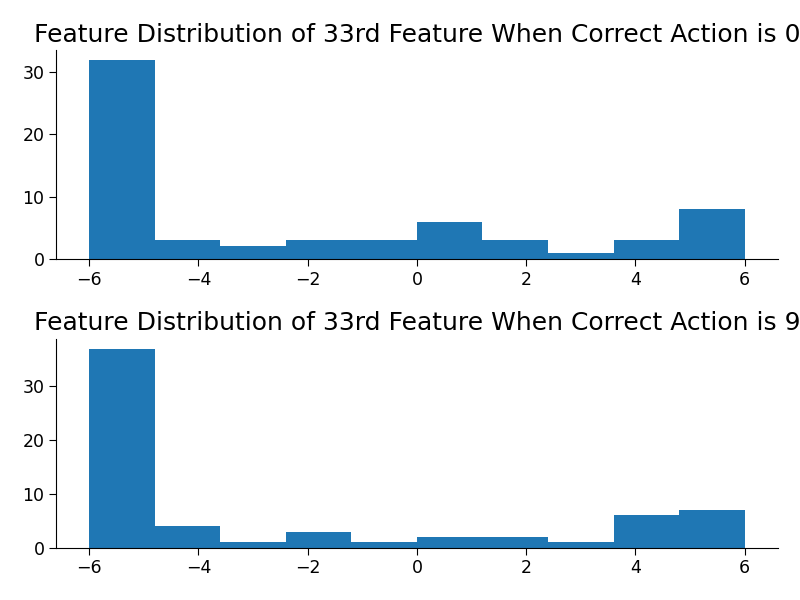

In [6]:
# and for scalar data always good to look at a histogram
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(Xs[y.flatten() == 0][3])
ax1.set_title('Feature Distribution of 33rd Feature When Correct Action is 0')
ax2.hist(Xs[y.flatten() == 9][33])
ax2.set_title('Feature Distribution of 33rd Feature When Correct Action is 9')
plt.show()

Looking at the distribution of this one particular feature across these two particular classes (Action 0 is correct vs. action 9 is correct), we see that from this feature alone we are unlikely to be be able to correctly discriminate between these two classes. Other features, and possibly combinations of features will be required for successful classification.

So this problem is too hard for our eyes and brains, but let's see if our perturbation learning model is able to learn this classification. Now that we have 10 possible output actions we are going to have to change the structure of our model slightly.

We still use a simple organism as the inspiration for this model. One that has an array of sensory input neurons corresponding to the features, which are in turn connected to a layer of (highly abstracted) motor output neurons, with each neuron in the outpur layer corresponding to one specific action. We imagine that the activation level of these output neurons roughly corresponds to a firing rate, and that the action actually taken is determined by which of these actions neurons fires first... It's a race! (Box on poisson process model of firing rates and poisson races).

We model this creature's sensory-behaviour system as follows. Let $\mathbf{x}$ be the raw sensory input (vector) in a given episode. We imagine that $\mathbf{x}$ corresponds to the activation level and firing rate of each photosensitive sensory neuron. These input neurons are then connected by a fully connected network of synapse to each of the output neurons. The activation level of the output neurons is computed as
$$\mathbf{y} = \mathbf{Wx} + \mathbf{b}$$
Here, $\mathbf{b}$ is a vector giving the bias, or baseline activation level of each of the output neurons and $\mathbf{W}$ is the strength of the synaptic weights between the input neurons and the output neurons, represented as a $\text{(number of actions)} \times \text{(number of features)}$ matrix. To streamline notation, exposition, and algorithm implementation we will typically "hide" the bias term $\mathbf{b}$ by augmenting the base feature set with a new constant valued feature. Then, the baises become the corresponding column of $\mathbf{W}$. (A quick notation reminder: bold lowercase letters typically represent column vectors, bold uppercase letters typically denote matrices or higher-order tensors.)

We then use softmax normalization to transform these activations into a probability distribution over the possible actions. Recall that softmax normalization of a vector is defined as
$$\text{softmax}(y_i) := \frac{e^{y_i}}{\sum_{j} e^{y_j}}$$

So the probability that action $i$ is taken given the softmax normalized value of the $i^{th}$ component of $\mathbf{y}$, that is $\text{softmax}(y_i)$. Thus the weights $\mathbf{W}$ define the organism's policy under this model.

--Picture of this very simple neural circuit here--

Having established how behaviour is determined by sensory input, $\mathbf{x}$, and parameters $\mathbf{W}$ i.e. our policy, we a rule for modifying this policy based on environmental feedback.

As in the previous sequence our goal is still to come up with a rule that prescribes changes to the synaptic weights $\mathbf{W}$ in such a way that the reward obtained over time increases (and ideally approaches the theoretical maximum over many learning trials). Let's see how our mini-batched measure and update rule works on this problem. The measure and update or weight perturbation update rule is as follows.
$$ \text{Parameter Update} = \alpha \cdot \frac{\text{Measured Perturbation in Performance}}{\text{Perturbation in Parameters}}$$

where $\alpha$ is some constant of proportionality, in this case usually called the learning rate or step-size meta-parameter of the learning algorithm.

Let's try it and see.

In [7]:
# Before augmentation this is the shape of the feature set
print(f'Shape of features before augmentation: {Xs.shape}')
Xs.shape
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])
print(f'Shape of features after augmentation: {Xs_aug.shape}')

# We also want to encode the labels as 1-hots and also the reward implications
# of each action for each stimuli to streamline the evaluations
y_one_hot = np.eye(10)[y.flatten()]
y_rewards = (2 * y_one_hot) - 1

Shape of features before augmentation: (5620, 64)
Shape of features after augmentation: (5620, 65)


In [8]:
y_one_hot[:10]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [9]:
y[:10]

array([[0],
       [0],
       [7],
       [4],
       [6],
       [2],
       [5],
       [5],
       [0],
       [8]])

In [10]:
y_rewards[:10]

array([[ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.],
       [-1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.],
       [-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.]])

In [11]:
def np_sigmoid(x):
  return 1 / (1 + np.exp(-x))

def np_softmax(x):
  x_shift = x - np.max(x, axis=0)
  return np.exp(x_shift) / np.sum(np.exp(x_shift), axis=0)

def eval_params(W, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(10) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(10) x batch np.array) target behavioural output as a vector
       of the rewards recieved for each action taken given the x value
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np.dot(W,x) # output x batch
  y_hat = np_softmax(h) # outnput x batch
  batch_expected_reward = np.sum(y * y_hat, axis=0)
  R_bar = np.mean(batch_expected_reward)
  return R_bar


def eval_params_accuracy_percision_recall(W, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(10) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(10) x batch np.array) target behavioural output as a 1-hot
       encoding the correct behaviour
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    accuracy: percentage of correct classifications in the batch
    percision: # correct deployments of action / # total deployments of action
    recall: # correct deployments of action / # total cases when that action was correct
  """
  h = np.dot(W,x) # output x batch
  selected_indices = np.argmax(h, axis=0) # output x batch
  selected = np.zeros_like(h)
  selected[selected_indices, range(h.shape[1])] = 1
  confusion = np.dot(y, selected.T) # outputs x outputs
  # row sums are true classifications, col sums are selected classifications
  accuracy = np.sum(np.diag(confusion)) / np.sum(confusion) if np.sum(confusion) > 0 else 0
  class_precision = np.divide(np.diag(confusion), np.sum(confusion, axis=1),
                              out=np.zeros_like(np.diag(confusion), dtype=float),
                              where=np.sum(confusion, axis=1)!=0)
  class_recall = np.divide(np.diag(confusion), np.sum(confusion, axis=0),
                           out=np.zeros_like(np.diag(confusion), dtype=float),
                           where=np.sum(confusion, axis=0)!=0)
  return accuracy, class_precision, class_recall, confusion

In [12]:
Xs_aug.shape

(5620, 65)

In [13]:
5620 / 20

281.0

In [14]:
W = np.zeros((10,65))
%timeit eval_params(W, Xs_aug.T, y_rewards.T)

2.5 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit eval_params(W, Xs_aug[:562,:].T, y_rewards[:562].T)

382 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Don't know if this isn't working because the algo is too slow or the model is not rich enough?

In [16]:
# @title Mini-Batched Measure and Update Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 100
alpha = 0.1 #learning rate or step size
num_batches = 20  # Number of mini-batches
batch_size = 281  # Size of each mini-batch
a = np.sqrt(6. / (10+65))
perturbation_scale = 2*a # std of gaussian perturbations
W_init = learn_rng.uniform(low=-a, high=a, size=(10,65))
W = W_init.copy()
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)  # Shuffle the indices for each epoch
  for batch in range(num_batches):
    # Select a mini-batch for this iteration
    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]
    X_batch = Xs_aug[batch_indices, :].T
    y_batch = y_rewards[batch_indices].T
    R_bar_old = eval_params(W, X_batch, y_batch)
    W_perturbations = learn_rng.normal(0, perturbation_scale, size=(10,65))
    #perturb and evaluate each W_j separately
    finite_differences_W = np.zeros(W.shape)
    for ii in range(W_perturbations.shape[0]):
      for jj in range(W_perturbations.shape[1]):
        original_value = W[ii,jj]
        W[ii, jj] += W_perturbations[ii, jj]
        R_bar_perturbed_Wij = eval_params(W, X_batch, y_batch)
        finite_differences_W[ii,jj] = (R_bar_perturbed_Wij - R_bar_old) / W_perturbations[ii,jj]
        W[ii,jj] = original_value  # Revert the perturbation

    delta_W = alpha * finite_differences_W
    W += delta_W

  if epoch == 0 or (epoch + 1) % 5 == 0:
    accuracy, _, _, _ = eval_params_accuracy_percision_recall(W, Xs_aug.T, y_one_hot.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch Accuracy: {accuracy:.6f} | Time elapsed: {elapsed_time:.2f} seconds')

Epoch 1/100 completed | Full Batch Accuracy: 0.352135 | Time elapsed: 1.89 seconds
Epoch 5/100 completed | Full Batch Accuracy: 0.561922 | Time elapsed: 9.47 seconds
Epoch 10/100 completed | Full Batch Accuracy: 0.573488 | Time elapsed: 18.75 seconds
Epoch 15/100 completed | Full Batch Accuracy: 0.578292 | Time elapsed: 27.95 seconds
Epoch 20/100 completed | Full Batch Accuracy: 0.669395 | Time elapsed: 37.17 seconds
Epoch 25/100 completed | Full Batch Accuracy: 0.769573 | Time elapsed: 46.49 seconds
Epoch 30/100 completed | Full Batch Accuracy: 0.861922 | Time elapsed: 55.93 seconds
Epoch 35/100 completed | Full Batch Accuracy: 0.870641 | Time elapsed: 65.28 seconds
Epoch 40/100 completed | Full Batch Accuracy: 0.873310 | Time elapsed: 74.58 seconds
Epoch 45/100 completed | Full Batch Accuracy: 0.874733 | Time elapsed: 83.79 seconds
Epoch 50/100 completed | Full Batch Accuracy: 0.875267 | Time elapsed: 93.09 seconds
Epoch 55/100 completed | Full Batch Accuracy: 0.875979 | Time elapsed

Alot depends on random initialization here so important not to draw conclusions from a single training run, this is the average learning trajectory of the above loop over twenty runs

In [17]:
accuracy, prec, recall, confusion = eval_params_accuracy_percision_recall(W, Xs_aug.T, y_one_hot.T)


By looking at the confusion matrix we can see that on this first run at least, this model learned to do a pretty good job correctly paring each of the 10 possible actions with the correct class of stimuli.

In [18]:
confusion

array([[552.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.],
       [  0., 551.,   1.,   0.,   0.,   0.,   1.,   3.,  10.,   5.],
       [  0.,   2., 547.,   2.,   0.,   0.,   1.,   1.,   3.,   1.],
       [  0.,   0.,   0., 560.,   0.,   7.,   0.,   0.,   3.,   2.],
       [  0.,   1.,   0.,   0., 554.,   0.,   3.,   0.,   5.,   5.],
       [  0.,   1.,   2.,   1.,   0., 548.,   1.,   0.,   0.,   5.],
       [  0.,   3.,   0.,   0.,   1.,   0., 554.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   2.,   1.,   0.,   0., 561.,   0.,   2.],
       [  1.,   9.,   2.,   0.,   3.,   5.,   0.,   0., 533.,   1.],
       [  0.,   6.,   0.,   3.,   1.,   2.,   0.,   4.,   5., 541.]])

So it's able to learn to discriminate between all the different classes, in about 3 minutes. That's pretty good, but could it be fasters?

# 2.1.2.2 Learning to do the right thing using the Delta Rule

Looking at the code block above this is because we must loop through every single parameter to make updates and there are 10 x 65 = 650 of these, so there are 650 evaluations just to do one full update of the parameters, so great that this works but it is so slow.

Now we had a similar number of units when we introduced a 10 unit hidden layer (10 x 65 + 10 x 1 = 660) to our binary discrimination task, and that performed relatively well. But that was also a much simpler problem.

Let's see if we can leverage what we know about the structure of the model to make more efficient parameter updates. We focus on how to update params based on the experience of a single training example at first.

A reward is recieved, if it is positive, this was good and in general we should reinforce the parameters by an amount that is proportional to their causal impact on bringing about the action choice that led to this reward. Similarly, if that reward is negative we should un-reinforce the parameters by an amount that is proportional to their causal impact on bringing about the action choice that led to this reward. Here is how we will achieve this.

We are going to treat the $\mathbf{y}$ as estimates of the reward that will be recieved when taking the corresponding action. (Then, the softmax normalization is how the critter translates these estimates of expected reward into a probability over actions). Taking this view, the organism only recieves information about the reward deriving from the particular action it took. If the reward is higher than what it expected the organism should update its parameters in a way that increases the expected reward when taking this action given the particular stimuli $\mathbf{x}$ conversely if the reward is lower than expected the organism should update its parameters in a way that decreases the expected reward when taking this action given this particular stimuli. One of the simplest possible update rules that achieves this is the 'Delta Rule' or sometimes called the Widrow-Hoff rule or Least Mean Square (LMS) method

$$\delta \mathbf{W}_{ij} =
\begin{cases}
\alpha \cdot (r - \mathbf{y}_i) \cdot x_j & \text{if } i = a, \\
0 & \text{if } i \neq a.
\end{cases}
$$

Here, $\mathbf{y}_i$ is the $i^{th}$ element of $\mathbf{y}$ and $\mathbf{x}_j$ is the $j^{th}$ element of $\mathbf{x}$. Notice that only the weights directly responsible for estimating the reward from the chosen action are updated.

Many of the learning rules we encounter will have this basic form: The update of a parameter will be proportional to some error signal or divergence between an expected/predicted/anticipated value and an observed value, in this case $y_i$ gives the expected reward when taking action $a=i$ conditional on stimuli/input pattern $\mathbf{x}$ and $r$ is the actual reward recieved so $(r-\mathbf{y}_i)$ is that error term. The parameter update will also be proportional to the causal relevance of that term for the error, in this case this is captured by the $\mathbf{x}_j$ term. If $\mathbf{x}_j$ was zero in this case $\mathbf{W}_{ij}$ would have had no bearing on $\mathbf{y}_i$ and so there would be no update. When $x_j$ is non-zero the sign (+/-) of $\mathbf{x}_j$ aligns the parameter change correctly with the type of error. So that $\mathbf{W}_ij$ increases both when the predicted reward is less than the actual with $\mathbf{x}_j$ positive and when the predicted reward is greater than the actual with $\mathbf{x}_j$ negative; and conversely $\mathbf{W}_ij$ decreases both when the predicted reward is less than the actual with $\mathbf{x}_j$ negative and when the predicted reward is greater than the actual with $\mathbf{x}_j$ positve.

Now let's program a training loop that uses this new update rule. First we need to code up an explicit action selection function. Previously, in our eval params function we were simply taking expected values, given the organism's probabilities of taking different actions. Now, however our update rule really only makes sense when a particular actions is taken and a particular reward is recieved.

In [19]:
def select_action(W, x, rng=None, temp=1, type='deterministic', ):
  """
  Chooses actions based on a simple behaviour circuit, with parameters W
  given inputs x. Choice is deterministic or stochastic as determined by type.
  If stochastic we use softmax selection with temp and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(10) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    temp: scalar temperature parameter for softmax selection, low values make it
          closer to deterministic, high values make it closer to uniform random
          selection
    type: 'deterministic' or 'stochastic'
  Returns:
    selected_action_index, selected_action_probabilities, selected_aciton_one_hot
  """
  if rng is None:
    rng = np.random.default_rng(0)
  v = np.dot(W, x) # (output x batch)
  if type == 'deterministic':
    selected_indices = np.argmax(v, axis=0) # output x batch
  elif type == 'stochastic':
    v_shift = v - np.max(v, axis=0)
    selection_probs = np.exp(v_shift / temp) / np.sum(np.exp(v_shift / temp), axis=0)
    cs_selection_probs = np.cumsum(selection_probs, axis=0)
    rands = rng.random(size=(1, v.shape[1]))
    is_greater = cs_selection_probs > rands
    selected_indices = np.argmax(is_greater, axis=0)
  else:
    raise ValueError(f'Unknown type {type}')
  selected = np.zeros_like(v)
  selected[selected_indices, range(v.shape[1])] = 1
  return selected_indices, selected, v

def eval_params(W, x, y, use_expectation=True):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(10) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(10) x batch np.array) target behavioural output as a vector
       of the rewards recieved for each action taken given the x value
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np.dot(W,x) # output x batch
  y_hat = np_softmax(h) # outnput x batch
  if use_expectation:
    batch_expected_reward = np.sum(y * y_hat, axis=0)
    R_bar = np.mean(batch_expected_reward)
  else:
    selected_indices, selected, v = select_action(W, x, temp=1, type='stochastic')
    actual_rewards = y[selected_indices, range(y.shape[1])]
    R_bar = np.mean(actual_rewards)
  return R_bar

In [20]:
learn_rng = np.random.default_rng(0)
num_epochs = 20000
alpha = 0.0000006 #learning rate or step size
a = np.sqrt(6. / (10+65))
W_init = learn_rng.uniform(low=-a, high=a, size=(10,65))
W = W_init.copy()
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  selected_actions, selected_one_hot, v = select_action(W, Xs_aug.T, rng=learn_rng, type='stochastic')
  range_index = np.arange(len(selected_actions))
  y_selected = y_rewards[range_index, selected_actions].T
  v_selected = v[selected_actions, range_index]
  delta_W = np.zeros_like(W)
  for action in range(W.shape[0]):
    action_mask = selected_actions == action
    if np.any(action_mask):
      # stimuli that caused actions of this type
      X_relevant = Xs_aug.T[:, action_mask]  # input x num actions of this type
      # reward errors for actions of this type
      reward_error = y_selected[action_mask] - v_selected[action_mask] # num_actions of this type
      reward_error = reward_error[np.newaxis, :]  # (1, num_actions of this type)
      delta_W[action, :] = np.sum(alpha * X_relevant * reward_error, axis=1)
  W += delta_W

  if epoch == 0 or (epoch + 1) % 500 == 0:
    accuracy, _, _, _ = eval_params_accuracy_percision_recall(W, Xs_aug.T, y_one_hot.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch Accuracy: {accuracy:.6f} | Time elapsed: {elapsed_time:.2f} seconds')

Epoch 1/20000 completed | Full Batch Accuracy: 0.080961 | Time elapsed: 0.02 seconds
Epoch 500/20000 completed | Full Batch Accuracy: 0.498932 | Time elapsed: 5.40 seconds
Epoch 1000/20000 completed | Full Batch Accuracy: 0.670819 | Time elapsed: 10.68 seconds
Epoch 1500/20000 completed | Full Batch Accuracy: 0.816548 | Time elapsed: 16.48 seconds
Epoch 2000/20000 completed | Full Batch Accuracy: 0.873488 | Time elapsed: 21.74 seconds
Epoch 2500/20000 completed | Full Batch Accuracy: 0.905516 | Time elapsed: 27.35 seconds
Epoch 3000/20000 completed | Full Batch Accuracy: 0.925089 | Time elapsed: 32.62 seconds
Epoch 3500/20000 completed | Full Batch Accuracy: 0.933630 | Time elapsed: 38.28 seconds
Epoch 4000/20000 completed | Full Batch Accuracy: 0.938256 | Time elapsed: 43.43 seconds
Epoch 4500/20000 completed | Full Batch Accuracy: 0.942171 | Time elapsed: 48.60 seconds
Epoch 5000/20000 completed | Full Batch Accuracy: 0.943772 | Time elapsed: 53.89 seconds
Epoch 5500/20000 completed 

It seems a bit faster, but not that much faster. This is because the comparison isn't really fair. In our measure and update loop we're using the proper expected reward, whereas in this reward-expectation error driven update we're using a specific sample of the reward based on actual sampled actions. Here's a version of our measure and update rule using actual sampled actions instead

It's difficult to compare these directly, since the perturbation method with actual action sampling requires getting the purturbation scale dialed in just right so that perturbations are likely to change actual behavioural outcomes, in contrast if we just look at expectations there is a lot of information coming in there, basically every single action is able to evaluated at once. In contrast

In [21]:
# @title Mini-Batched Measure and Update Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 100
alpha = 0.1 #learning rate or step size
num_batches = 20  # Number of mini-batches
batch_size = 281  # Size of each mini-batch
a = np.sqrt(6. / (10+65))
perturbation_scale = 2*a # std of gaussian perturbations
W_init = learn_rng.uniform(low=-a, high=a, size=(10,65))
W = W_init.copy()
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)  # Shuffle the indices for each epoch
  for batch in range(num_batches):
    # Select a mini-batch for this iteration
    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]
    X_batch = Xs_aug[batch_indices, :].T
    y_batch = y_rewards[batch_indices].T
    R_bar_old = eval_params(W, X_batch, y_batch)
    W_perturbations = learn_rng.normal(0, perturbation_scale, size=(10,65))
    #perturb and evaluate each W_j separately
    finite_differences_W = np.zeros(W.shape)
    for ii in range(W_perturbations.shape[0]):
      for jj in range(W_perturbations.shape[1]):
        original_value = W[ii,jj]
        W[ii, jj] += W_perturbations[ii, jj]
        R_bar_perturbed_Wij = eval_params(W, X_batch, y_batch, use_expectation=False)
        finite_differences_W[ii,jj] = (R_bar_perturbed_Wij - R_bar_old) / W_perturbations[ii,jj]
        W[ii,jj] = original_value  # Revert the perturbation

    delta_W = alpha * finite_differences_W
    W += delta_W

  if epoch == 0 or (epoch + 1) % 5 == 0:
    accuracy, _, _, _ = eval_params_accuracy_percision_recall(W, Xs_aug.T, y_one_hot.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch Accuracy: {accuracy:.6f} | Time elapsed: {elapsed_time:.2f} seconds')

Epoch 1/100 completed | Full Batch Accuracy: 0.094662 | Time elapsed: 6.33 seconds
Epoch 5/100 completed | Full Batch Accuracy: 0.094662 | Time elapsed: 32.03 seconds
Epoch 10/100 completed | Full Batch Accuracy: 0.037367 | Time elapsed: 64.45 seconds
Epoch 15/100 completed | Full Batch Accuracy: 0.074733 | Time elapsed: 98.20 seconds
Epoch 20/100 completed | Full Batch Accuracy: 0.061388 | Time elapsed: 132.52 seconds
Epoch 25/100 completed | Full Batch Accuracy: 0.099644 | Time elapsed: 173.84 seconds
Epoch 30/100 completed | Full Batch Accuracy: 0.099644 | Time elapsed: 218.87 seconds
Epoch 35/100 completed | Full Batch Accuracy: 0.099644 | Time elapsed: 263.95 seconds
Epoch 40/100 completed | Full Batch Accuracy: 0.099644 | Time elapsed: 308.57 seconds
Epoch 45/100 completed | Full Batch Accuracy: 0.099644 | Time elapsed: 353.71 seconds
Epoch 50/100 completed | Full Batch Accuracy: 0.099644 | Time elapsed: 398.72 seconds
Epoch 55/100 completed | Full Batch Accuracy: 0.099644 | Time

In [22]:
selected_indices, selected, v = select_action(W, Xs_aug.T, rng=learn_rng, type='stochastic')

In [23]:
selected_indices

array([9, 9, 9, ..., 9, 9, 9])

In [24]:
y_rewards.shape

(5620, 10)

In [25]:
selected_indices.shape

(5620,)

In [26]:
y_rewards[np.arange(len(selected_indices)), selected_indices].shape

(5620,)

In [27]:
v.T[np.arange(len(selected_indices)), selected_indices].shape

(5620,)

In [28]:
np.mean((y - v)**2)

ValueError: operands could not be broadcast together with shapes (5620,1) (10,5620) 

In [ ]:
v.shape

We're going to really want to walk through this step by step and see how the probability of the action taken increases or decrease, and then how by definition the probability of all the other actions goes up or down to balance this change.

In [ ]:
accuracy, prec, recall, confusion = eval_params_accuracy_percision_recall(W, Xs_aug.T, y_one_hot.T)

In [ ]:
np.sum(confusion, axis=0, keepdims=True)

This is what 'propose and reject' looks like for this harder problem:

In [ ]:
# @title Propose and Reject Training Loop


In [ ]:
################################################################################
# TODO for students: Complete the lines with ... to implement a parameter
# evaluation function
raise NotImplementedError("Exercise: parameter evaluation")
################################################################################


def np_sigmoid(x):
  return 1 / (1 + np.exp(-x))


def eval_params_slow(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use for loops to think carefully about what we're doing
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (1 np.array x batch) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (1 np.array x batch) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  batch_len = x.shape[1]
  h = np.zeros((1, batch_len))
  y_hat = np.zeros((1, batch_len))
  R_total = 0
  for ii in range(batch_len):
    h[0,ii] = ...
    y_hat[0,ii] = np_sigmoid(...)
    # y_hat is our probability of striking
    # compute the expected score
    if y[0,ii] == 1:
      # supposed to strike
      # with probability y_hat creature strikes and gets a point
      R_total += y_hat[0,ii] * 1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    elif y[0,ii] == 0:
      # not supposed to strike
      # with probability y_hat creature strikes and loses a point
      R_total += y_hat[0,ii] * -1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    else:
      raise ValueError(f'Unexpected target: {y[ii,0]}')
  R_avg = R_total / batch_len
  return R_avg


def eval_params(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (batch x 1 np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (batch x 1 np.array) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = w * x + b
  y_hat = np_sigmoid(h)
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_avg = np.mean(batch_expected_reward)
  return R_avg

In [ ]:
# to_remove solution

def np_sigmoid(x):
  return 1 / (1 + np.exp(-x))


def eval_params_slow(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use for loops to think carefully about what we're doing
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (1 np.array x batch) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (1 np.array x batch) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  batch_len = x.shape[1]
  h = np.zeros((1, batch_len))
  y_hat = np.zeros((1, batch_len))
  R_total = 0
  for ii in range(batch_len):
    h[0,ii] = w * x[0,ii] + b
    y_hat[0,ii] = np_sigmoid(h[0,ii])
    # y_hat is our probability of striking
    # compute the expected score
    if y[0,ii] == 1:
      # supposed to strike
      # with probability y_hat creature strikes and gets a point
      R_total += y_hat[0,ii] * 1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    elif y[0,ii] == 0:
      # not supposed to strike
      # with probability y_hat creature strikes and loses a point
      R_total += y_hat[0,ii] * -1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    else:
      raise ValueError(f'Unexpected target: {y[ii,0]}')
  R_avg = R_total / batch_len
  return R_avg


def eval_params(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (batch x 1 np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (batch x 1 np.array) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = w * x + b
  y_hat = np_sigmoid(h)
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_avg = np.mean(batch_expected_reward)
  return R_avg

In this exercise, we actually implemented the same function twice, once using a for loop to iterate over the (mini-)batch of inputs and targets, and once using NumPy broadcasting to compute the batch reward (roughly) in parallel. Run the following code cells to see what kind of computational efficiency this buys us.

In [ ]:
X_simple_1_feature.T.shape

In [ ]:
eval_params_slow(1, 0, X_simple_1_feature.T, y1_simple.T)

In [ ]:
eval_params(1, 0, X_simple_1_feature.T, y1_simple.T)

In [ ]:
%timeit eval_params_slow(1, 0, X_simple_1_feature.T, y1_simple.T)

In [ ]:
%timeit eval_params(1, 0, X_simple_1_feature.T, y1_simple.T)

In our specific example (on the specific COLAB instance we're writing this on in 2024), the broadcasting approach in Python, using NumPy, is approximately 50 times faster than using for-loops. This is because for-loops in interpreted languages like Python incur significant overhead at each iteration, but also because potential dependencies between loop iterations limit parallelization. In contrast, broadcasting allows for vectorized operations, enabling parallel execution that can harness more of the underlying hardware's computational power. NumPy enhances this efficiency further by utilizing highly optimized, pre-compiled linear algebra libraries (primarily hardware-specific implementations of BLAS and LAPACK). The same principles apply (though are sometimes less critical) in compiled languages or with Just-In-Time (JIT) compilation frameworks like JAX. Broadcasting or tensor notation not only improves performance but also maintains code brevity and alignment with mathematical notation. As scientists and programmers, we do not need to understand every detail of how the magic of computational parallelism allows for fast linear algebra, but it is crucial to appreciate the potential impacts on computational efficiency.

Okay, so we have the ability to evaluate the parameters in terms of the average score they yield when applied across the whole dataset of example pairs of sensory inputs and correct actions. In each iteration of our learning (training) loop, we will perturb our parameters using Gaussian noise and ***measure the relationship*** between the parameter changes and the average expected reward as determined by our evaluation function. After measuring this relationship, we will update each parameter in proportion to the rate of improvement of the score with respect to the change in the underlying parameter.

In [ ]:
# @title Measure and Update Training Loop

In [ ]:
################################################################################
# TODO for students: Complete the lines with ... to implement a parameter
# evalution function
raise NotImplementedError("Exercise: Measure and Update Training Loop")
################################################################################


learn_rng = np.random.default_rng(0)
num_learning_episodes = 100000
alpha = 100 #learning rate / step size
perturbation_scale = 0.01 # std of Gaussian parameter perturbations
w_init = 1
b_init = 0
w = w_init
b = b_init
start_time = time.time()
for ii in range(num_learning_episodes+1):
  R_bar_old = eval_params(w, b, X_simple_1_feature.T, y1_simple.T)
  # perturb w and evaluate
  w_perturbation = learn_rng.normal(0, perturbation_scale)
  w_perturbed = w + ...
  R_bar_perturbed_w = eval_params(..., b, X_simple_1_feature.T, y1_simple.T)
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_perturbed = b + ...
  R_bar_perturbed_b = eval_params(..., b_perturbed, X_simple_1_feature, y1_simple)
  # estimate rate of change of reward for each parameter
  finite_difference_w = ...
  finite_difference_b = ...
  # update parameters based on finte difference estimate rate of change
  # of reward with respect to parameters
  delta_w = alpha * finite_difference_w
  delta_b = alpha * finite_difference_b
  w += delta_w
  b += delta_b

  if ii == 0 or ii % 5000 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"w":>1}={w:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_old:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

In [ ]:
# to_remove solution

learn_rng = np.random.default_rng(0)
num_learning_episodes = 100000
alpha = 100 #learning rate / step size
perturbation_scale = 0.01 # std of Gaussian parameter perturbations
w_init = 1
b_init = 0
w = w_init
b = b_init
start_time = time.time()
for ii in range(num_learning_episodes+1):
  R_bar_old = eval_params(w, b, X_simple_1_feature.T, y1_simple.T)
  # perturb w and evaluate
  w_perturbation = learn_rng.normal(0, perturbation_scale)
  w_perturbed = w + w_perturbation
  R_bar_perturbed_w = eval_params(w_perturbed, b, X_simple_1_feature.T, y1_simple.T)
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_perturbed = b + b_perturbation
  R_bar_perturbed_b = eval_params(w, b_perturbed, X_simple_1_feature, y1_simple)
  # estimate rate of change of reward for each parameter
  finite_difference_w = (R_bar_perturbed_w - R_bar_old) / w_perturbation
  finite_difference_b = (R_bar_perturbed_b - R_bar_old) / b_perturbation
  # update parameters based on finte difference estimate rate of change
  # of reward with respect to parameters
  delta_w = alpha * finite_difference_w
  delta_b = alpha * finite_difference_b
  w += delta_w
  b += delta_b

  if ii == 0 or ii % 5000 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"w":>1}={w:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_old:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

Is an R_bar of 0.4951... good or bad? Let's look at the data. How many striking opportunities are there, versus situation where no-strike is best?

In [ ]:
# number of striking opportunities
np.sum(y1_simple == 1)

In [ ]:
#number of non-strike situations
np.sum(y1_simple == 0)

In [ ]:
# proportion of situations where a point can be earned
571 / (571 + 554)

So, back to our question: Is an average score of 0.4951... per round good? Well, yes. A perfect score is ~0.5075. Given that we have only a single feature - that can't perfectly separate the two cases as the feature distributions for each case overlap - we are bound to have a few false positives and false negatives. These will lower the score a bit, but for the most part, this is roughly as good as can be expected.

**Algorithmic Thinking Exercise:**

In the 'measure and update' learning loop implemented above, we perturb each parameter, measure the effect of perturbations, and then update the parameters. Alternatively we could have perturbed the $w$ parameter, evaluated and then updated the $w$ parameter, and then perturbed the $b$ parameter, evaluated, and then updated the $b$ parameter.
1. In the implementation above how many times is the `eval_params` function called per iteration?

  (Answer: 3)
2. If we used the alternative method where each parameter is updated and evaluated separately, how many times would eval_params need to be called per iteration?

  (Answer: 4, After updating $w$ we can't simply use `R_bar_old` to measure the change in performance from changing $b$ since `R_bar_perturbed_b` will be computed using the updated $w$. An `R_bar_new_w_old_b` will need to be computed and used to inform the changes to $b$.)
3. If we had $n$ parameters instead of 2, how many times would the `eval_params` function be called per iteration in the implementation above?

  (Answer: $n+1$)
4. If we had $n$ parameters instead of 2, how many times would the `eval_params` function be called per iteration in the alternate implementation?

  (Answer: $2n$)

Little details like this in implementation can make big differences to algorithm speed. Note though that this slower alternative isn't quite a dead loss. Technically the parameter updates made by the alternative algorithm, will be 'better' (precisely what we mean by better we leave aside for the moment), however, in this particular case the 'betterness' of the parameter updates is not enough to make up for the added computational cost of calling `eval_params` and extra $n-1$ times.

Okay, now just as a sanity and intuition check, two questions:
1. Do we get the same answer when we use a propose and reject method?  
2. Is the propose and reject method quicker or slower at finding the solution?
Let's quickly adapt the adapt 'measure and update' learning loop to do 'propose and reject' instead.

In [ ]:
# @title Propose And Reject Training Loop
learn_rng = np.random.default_rng(0)
num_learning_episodes = 50000
perturbation_scale = 0.1 # std of Gaussian parameter perturbations
w_init = 1
b_init = 0
w = w_init
b = b_init
start_time = time.time()  # Record the start time
R_bar_best = eval_params(w, b, X_simple_1_feature.T, y1_simple.T)
for ii in range(num_learning_episodes+1):
  # perturb w and evaluate
  w_perturbation = learn_rng.normal(0, perturbation_scale)
  w_proposed = w + w_perturbation
  R_bar_proposed = eval_params(w_proposed, b, X_simple_1_feature, y1_simple)
  if R_bar_best < R_bar_proposed:
    w = w_proposed
    R_bar_best = R_bar_proposed
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_proposed = b + b_perturbation
  R_bar_proposed = eval_params(w, b_proposed, X_simple_1_feature, y1_simple)
  if R_bar_best < R_bar_proposed:
    b = b_proposed
    R_bar_best = R_bar_proposed

  if ii == 0 or ii % 5000 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"w":>1}={w:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_best:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

Both 'Propose and Reject' and 'Measure and Update' get to similar answers, but 'Propose and Reject' gets there much more quickly. In part, this is because there are fewer calls to `eval_params` per iteration (2 instead of 3). Additionally, this is because the step size in parameter space remains relatively constant throughout the 'Propose and Reject' process, while in the 'Measure and Update' method, the step size in parameter space diminishes as the relative improvements in performance decrease. For these reasons, our initial hope that 'Measure and Update' might be more efficient that 'Propose and Reject' is not born out in this simple problem.

-- animation of propose and reject versus measure and update in this simple 2 parameter problem --

A couple things to think about here:
1. In our 'Measure and Update' implementation above we make one perturbation and one measurement of change in reward for each parameter. What would happen if we perturbed every parameter at once and then made a single measurement of change in reward? There would only be two calls to `eval_params` per iteration, regardless of the number of parameters. Together these two `eval_params` would measure the combined effect of all the parameter changes on reward. As a result the estimated effect of any one parameter on the reward would be polluted by the effects of all the other parameter perturbations. Whether this improves or breaks the algorithm will depend on whether the efficiency from fewer `eval_params` calls compensate for the noise introduced, or if the noise make these faster parameter updates fundamentally unhelpful? In other words is it better to take more/quicker noisy steps in parameters space or fewer/slower steps in better directions?
2. In the learning loops above the impact on reward for a perturbation is measured using the entirety of the data set available to us. In this example the data set is only ~1000 examples, but what if it consisted of trillions of examples, would it still make sense to use the entire data set to evaluate each perturbation or would it be better to evaluate parameter changes using a smaller sample from this data set? Using a smaller sample will often make evaluations faster at the price of introducing noise to the estimate of rate of reward change (on the full data set) with respect to parameter changes. Again, this is question of more/quicker noisy steps or fewer/slower careful steps in parameters space.
3. In the learning loops above we measure the relationship between parameter changes and reward changes using a single perturbation, but could we make better parameter updates if we measured using many perturbations before updating the parameters? This would require making more evaluations per update. Whether is this is a good or bad idea again comes down to a question of more/quicker noisy parameter updates versus fewer/slower careful parameter updates. What is the right balance?

For this very straightforward problem these questions may seem kind of beside the point. We have a good answer, and it didn't take too long to get, why worry about these details now? We don't really need to now, but as we'll soon see, these details become increasingly relevant as we work to extend this 'measure and update' approach to a more complex problem. Indeed, the trade-off between more/quick noisy steps and few/slow careful steps is one of the fundamental questions at the dark heart of Machine Learning.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 2.1.1.2: Learning to Do the Right Thing - Harder
In the previous section, we worked on a pretty simple discrimination problem, there was a single feature that, for the most part, correlated with correct times to strike and not-strike. Now we're going to look at a slightly harder problem, where the answer is less obvious (to us at least). As before, given a sensory input pattern, the problem is to determine whether or not to strike. Again, try to maximize your average score for this new problem where the 'sensory' input is more complex.

In [ ]:
scramble_bin_hard = InteractiveMNISTPredator(features=Xs,
                                             labels=y1,
                                             feedback_type='both')
display(scramble_bin_hard.fig.canvas)
clear_output()
display(scramble_bin_hard.ui)

So now instead of a single feature to base our strike/no-strike discrimination on, we have 64 (8x8) features to potentially inform our decision. Will our simple setup from before readily generalize to this situation with richer sensory input? Let's find out.

We model this creature's sensory-behaviour system much as before. Now, $\mathbf{x}$ is the raw sensory input (vector) in a given episode. Each element $x_i$ of $\mathbf{x}$ corresponds to the activation level and firing rate of a single photosensitive neuron.

In [ ]:
# the data set we're working with has 5620 example sensory inputs,
# each consisting of 64 (8x8) values
print(Xs.shape)

In [ ]:
# this is the first example
print(Xs[0].reshape(8,8,))

In [ ]:
# visualizing the example we see that lower values correspond to darker pixels
# and higher values correspond to lighter values
fig, ax = plt.subplots(figsize=(4,4))
remove_ip_clutter(fig)
ax.imshow(Xs[0].reshape(8,8), cmap='gray')
plt.show()

These input neurons are then connected by synapses to a single output neuron. The activation level of this output neuron is computed as
$$y = \mathbf{Wx} + b$$
Here, $b$ is the (scalar) bias, or baseline activation level of the output neuron, and $\mathbf{W}$ is a matrix of synaptic weights between the input neurons and the single output neuron. (In this case where there is only one output neuron so $\mathbf{W}$ has shape 1x64 so could also be thought of as a row vector.)  As before, the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$

Recall that $\sigma(y): \frac{1}{1+e^{-y}} = \frac{e^y}{1+e^y}$ is the standard logistic (sigmoid) function.

In [ ]:
# the eval_params function needs to be adapted
# to work with this richer sensory input
def eval_params_rich(W, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(64) np.array)
       weights between sensory neurons and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np.dot(W,x) + b # 1 x batch
  y_hat = np_sigmoid(h) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.mean(batch_expected_reward)
  return R_bar

In [ ]:
eval_params_rich(np.ones((1,64)), 0, Xs.T, y1.T)

In [ ]:
%timeit eval_params_rich(np.ones((1,64)), 0, Xs.T, y1.T)

That's working and relatively quick now let's adapt our learning loop for this new setup.

In [ ]:
# @title Measure and Update Training Loop

learn_rng = np.random.default_rng(0)
num_learning_episodes = 2000
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
W_init = np.zeros((1,64))
b_init = 0
W = W_init
b = b_init
start_time = time.time()
for ii in range(num_learning_episodes+1):
  R_bar_old = eval_params_rich(W, b, Xs.T, y1.T)
  # get perturbations for W all at once
  W_perturbations = learn_rng.normal(0, perturbation_scale, size=(1,64))
  #perturb and evaluate each W_j separately
  finite_differences_W = np.zeros(W.shape)
  for j in range(W_perturbations.shape[1]):
    W_perturbed = np.copy(W)
    W_perturbed[0,j] += W_perturbations[0,j]
    R_bar_perturbed_Wj = eval_params_rich(W_perturbed, b, Xs.T, y1.T)
    finite_difference_Wj = (R_bar_perturbed_Wj - R_bar_old) / W_perturbations[0,j]
    finite_differences_W[0,j] = finite_difference_Wj
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_perturbed = b + b_perturbation
  R_bar_perturbed_b = eval_params_rich(W, b_perturbed, Xs.T, y1.T)
  # estimate rate of change of reward for each parameter
  finite_difference_b = (R_bar_perturbed_b - R_bar_old) / b_perturbation
  # update parameters based on finte difference estimate rate of change
  # of reward with respect to parameters
  delta_W = alpha * finite_differences_W
  delta_b = alpha * finite_difference_b
  W += delta_W
  b += delta_b

  if ii == 0 or ii % 100 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"W_0":>1}={W[0,0]:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_old:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

So it looks like this is learning to do an okay job. A quick inspection of the data tells us that doing perfect discrimination would give an average score of 0.503... per round.



In [ ]:
# There are this many cases where striking is the right thing to do
np.sum(y1 == 1)

In [ ]:
# And this many cases where striking is the wrong thing to do
np.sum(y1 == 0)

In [ ]:
# So this the average score per round with perfect discrimination
np.sum(y1 == 1) / (len(y1))

Without benchmarks, it's hard to know what level is possible given this particular dataset and discrimination task using this particular sensory-behaviour circuit. Not only are we unsure if this is a good result in a general sense, but we also don't know whether our less-than-perfect performance is due to limitations of the circuit architecture (the model in ML terms) or our learning algorithm's inability to find optimal parameters for the given architecture. We could always let the above learning process run for a really long time and see where it stops, but who wants to wait around for results, not us. Let's see if we can come up with some faster learning processes for this sensory-behaviour circuit.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 2.1.1.3: Learning to Do the Right Thing - Faster

In our simple problem 'propose and reject' was quite effective, let's see how it fares in this more complex problem. First, though, to make our programming and notation a little cleaner we are going 'hide' our bias term. We to do this by augmenting the features to include a feature that always has the value '1'. Then, the 'weight' associated with this feature, which always has a value of '1', will effectively serve as the bias term.

This 'propose and reject' method was faster, in that, although it took as long per iteration, the iterations got to a higher `R_bar` more quickly. Again we could run this for a long time and see where improvement really caps out, but we wont' just now.

An important idea for speeding up learning is the idea of a 'mini-batch'. Currently in our learning the impact on reward for a perturbation is measured using the entirety of the dataset available to us. If we were to use a smaller (but representative) sample of this data set for our evaluations of parameter perturbations, we could potentially speed things up significantly.

In [ ]:
Xs_aug.shape

Our dataset consists of 5620 examples to learn from. This size means the dataset can be nicely broken down into 10 mini-batches of 562. Let's find out how much faster our evaluation function is when using a mini-batch that is ten times smaller.

In [ ]:
W = np.zeros((1,65))
%timeit eval_params_aug(W, Xs_aug[:562,:].T, y1[:562].T)

In [ ]:
%timeit eval_params_aug(W, Xs_aug.T, y1.T)

We observe a 2-3x speed up in this case. One thing to notice is that this was not a 10x speedup. This is due to the 'algorithmic efficiencies of scale' inherent in our heavily optimized evaluation function, which utilizes numpy broadcasting. These efficiencies of scale are tied to underlying hardware implementations of the operations. Thus in practical ML contexts choosing a 'good' mini-batch size requires consideration of hardware specific efficiencies of scale, to answer the question how much worse are my parameter updates versus how much faster are they for a given mini-batch size.

In [ ]:
# @title Mini-Batched Measure and Update Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 800
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
num_batches = 10  # Number of mini-batches
batch_size = 562  # Size of each mini-batch
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)  # Shuffle the indices for each epoch
  for batch in range(num_batches):
    # Select a mini-batch for this iteration
    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]
    Xs_batch = Xs_aug[batch_indices, :].T
    y1_batch = y1[batch_indices].T
    R_bar_old = eval_params_aug(W, Xs_batch, y1_batch)
    W_perturbations = learn_rng.normal(0, perturbation_scale, size=(1,65))
    #perturb and evaluate each W_j separately
    finite_differences_W = np.zeros(W.shape)
    for jj in range(W_perturbations.shape[1]):
      original_value = W[0,jj]
      W[0, jj] += W_perturbations[0, jj]
      R_bar_perturbed_Wj = eval_params_aug(W, Xs_batch, y1_batch)
      finite_differences_W[0,jj] = (R_bar_perturbed_Wj - R_bar_old) / W_perturbations[0,jj]
      W[0,jj] = original_value  # Revert the perturbation

    delta_W = alpha * finite_differences_W
    W += delta_W

  if epoch == 0 or (epoch + 1) % 50 == 0:
    R_bar_full_batch = eval_params_aug(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch R_bar: {R_bar_full_batch:.6f} | Time elapsed: {elapsed_time:.2f} seconds')

Applying the mini-batch idea to the 'measure and update' process made it quicker, and perhaps it even performed a bit better than 'propose and reject'. However, it's important to note that comparisons between algorithms is challenging, as algorithm performance often depends heavily on the choice of meta-parameters, such as learning rate, perturbation scale, mini-batch size, etc., relative to the dataset and underlying model being optimized.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

# 2.1.1.4 Learning to Do the Right Thing - Better - Stronger
One thing that could be holding back performance on this discrimination problem is that our algorithms are not capable of finding the optimal parameters for the given model, but... we don't really think that is the case here. Another possibility is that our simple sensory-behaviour circuit is not flexible or complex enough to fully discriminate between the two types of input. There is good reason to think that this might be the case. Our current sensory-behavioural circuit is effectively equivalent to logistic regression, i.e. each feature can either inhibit or potentiate striking behaviour to varying degrees, but there is no possibility for conditional interaction between features. By 'conditional interaction,' we mean a scenario where, for instance, feature 1 typically inhibits the behavior, except when feature 2 is positive, under which condition feature 1 becomes potentiating. These kinds of feature interactions are impossible in the current model. One way to allow for such interactions is to augment the base set of features with composite features, e.g. incorporate all the pairwise products of the existing feature set, so that instead of 65 features (bias included) we have $(65^2 - 1) = 4224$ features to work with. This could work, but what if we want something that depends on the interaction of more than 2 features, adding higher order polynomial terms will quickly make the problem intractable (Reference appendix section on why hidden layers not polynomials if we do that). If we had some mechanistically grounded understanding or hypothesis about the relationship between the features and label could might be able to cherry pick some small subset of higher order interaction terms, but the ML/supervised learning framework is in large part about automating the feature selection processes based on the data alone. In turns out that instead of resorting the regression on polynomial terms to capture feature interactions, there is a much more compact and expressive way of allowing for feature interactions. The idea is to allow for feature interactions to emerge as needed in a 'hidden' computational layer of our highly abstracted neurons.

As before $\mathbf{x}$ is the raw sensory input (vector) in a given episode and each element of $\mathbf{x}$ corresponds to the activation level and firing rate of a single photosensitive neuron.
These input neurons are then connected by synapses to a 'hidden layer' of intermediate computational neurons, say 10 of them. The activation level of these hidden layer neurons is computed as
$$\mathbf{h} = \sigma(\mathbf{W}_{in} \cdot \mathbf{x})$$
Now $\mathbf{W}_{in}$ is a matrix of synaptic weights between the input neurons and the hidden layer neurons, and $\cdot$ denotes standard matrix vector multiplication. (In this case $\mathbf{W}$ has shape $10 \times 64$. Each the values in the $i^{th}$ row of $\mathbf{W}_{in}$ given the sign and strength of the connections coming into the $i^{th}$ element of $h$ and similarly each value in the $j^{th}$ column of $\mathbf{W}_{in}$ corresponds to connection strengths coming out of the $j^{th}$ sensory input neuron.)  We still us $\sigma$ to represent the standard logistic sigmoid function, but in these case applied elementwise the vector output of the product $\mathbf{W}_{in} \cdot \mathbf{x}$. Then much as before our striking probability is computed as
$$y = \mathbf{W}_{out} \cdot \mathbf{h}$$
and
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$
Here $\mathbf{W}_{out}$ has shape $1  \times 10$.


We will need to write a new eval params function for this new model, let's do it.

In [ ]:
def eval_params_hidden(W_in, W_out, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W_in: (hidden-neurons(20) x inputs(65) np.array)
           weights between sensory neurons and hidden layer neurons
    W_out: (output(1) x hidden-neurons(20) np.array)
           weights between hidden layer neurons and output
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np_sigmoid(np.dot(W_in,x)) # hidden x batch
  y_hat = np_sigmoid(np.dot(W_out,h)) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.mean(batch_expected_reward)
  return R_bar

We've got a more complicated circuit with more parameters, how much longer does it take us to evaluate?

In [ ]:
W = np.zeros((1,65))
%timeit eval_params_aug(W, Xs_aug[:562,:].T, y1[:562].T)

In [ ]:
W_in = np.zeros((10,65))
W_out = np.zeros((1,10))
%timeit eval_params_hidden(W_in, W_out, Xs_aug[:562,:].T, y1[:562].T)

We're added a lot more operations here, and now our sensory to behaviour function takes about 4x times longer to evaluate. What if we made our minibatch really small, like 20, so that we had 261 mini-batches each of size 20, how much of a speed up does that give us?

In [ ]:
%timeit eval_params_hidden(W_in, W_out, Xs_aug[:10,:].T, y1[:10].T)

Okay that's starting to be pretty quick again, but we have a lot more parameters to evaluate, $11 \times 65 = 715$, as contrasted with $65$ from our more simple circuit? Can the mini-batched measure and update training loop, find good parameters is reasonable amount of time?

In [ ]:
# @title 10 Hidden Units - Measure and Update Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 20
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
num_batches = 261  # Number of mini-batches
batch_size = 20  # Size of each mini-batch
num_hidden_units = 10
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + num_hidden_units))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(num_hidden_units, 65))
out_init = np.sqrt(6 / (10 + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, num_hidden_units))
W_in = W_in_init
W_out = W_out_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)  # Shuffle the indices for each epoch
  for batch in range(num_batches):
    # Select a mini-batch for this iteration
    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]
    Xs_batch = Xs_aug[batch_indices, :].T
    y1_batch = y1[batch_indices].T
    R_bar_old = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch)
    W_in_perturbations = learn_rng.normal(0, perturbation_scale, size=W_in.shape)
    W_out_perturbations = learn_rng.normal(0, perturbation_scale, size=W_out.shape)
    #perturb and evaluate each parameter separately
    finite_differences_W_in = np.zeros(W_in.shape)
    for ii in range(W_in_perturbations.shape[0]):
      for jj in range(W_in_perturbations.shape[1]):
        original_value = W_in[ii,jj]
        W_in[ii,jj] += W_in_perturbations[ii,jj] # perturb
        R_bar_perturbed = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch) #evaluate
        finite_differences_W_in[ii,jj] = (R_bar_perturbed - R_bar_old) / W_in_perturbations[ii,jj]
        W_in[ii,jj] = original_value  # Revert the perturbation
    finite_differences_W_out = np.zeros(W_out.shape)
    for ii in range(W_out_perturbations.shape[0]):
      for jj in range(W_out_perturbations.shape[1]):
        original_value = W_out[ii,jj]
        W_out[ii,jj] += W_out_perturbations[ii,jj] # perturb
        R_bar_perturbed = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch) #evaluate
        finite_differences_W_out[ii,jj] = (R_bar_perturbed - R_bar_old) / W_out_perturbations[ii,jj]
        W_out[ii,jj] = original_value  # Revert the perturbation

    delta_W_in = alpha * finite_differences_W_in
    W_in += delta_W_in
    delta_W_out = alpha * finite_differences_W_out
    W_out += delta_W_out

  R_bar_full_batch = eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T)
  elapsed_time = time.time() - start_time
  print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch R_bar: {R_bar_full_batch:.6f} | Time elapsed: {elapsed_time:.2f} seconds')

So this new, more complex circuit is great. We're much closer to the theoretical maximum performance of 0.5033807829181495, maybe with a few more hidden units, and a little longer training time we could have perfect discrimination. Let's see what happens when we go up to 20 hidden units.

In [ ]:
# @title 20 Hidden Units - Measure and Update Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 20
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
num_batches = 261  # Number of mini-batches
batch_size = 20  # Size of each mini-batch
num_hidden_units = 20
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + num_hidden_units))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(num_hidden_units, 65))
out_init = np.sqrt(6 / (10 + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, num_hidden_units))
W_in = W_in_init
W_out = W_out_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)  # Shuffle the indices for each epoch
  for batch in range(num_batches):
    # Select a mini-batch for this iteration
    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]
    Xs_batch = Xs_aug[batch_indices, :].T
    y1_batch = y1[batch_indices].T
    R_bar_old = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch)
    W_in_perturbations = learn_rng.normal(0, perturbation_scale, size=W_in.shape)
    W_out_perturbations = learn_rng.normal(0, perturbation_scale, size=W_out.shape)
    #perturb and evaluate each parameter separately
    finite_differences_W_in = np.zeros(W_in.shape)
    for ii in range(W_in_perturbations.shape[0]):
      for jj in range(W_in_perturbations.shape[1]):
        original_value = W_in[ii,jj]
        W_in[ii,jj] += W_in_perturbations[ii,jj] # perturb
        R_bar_perturbed = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch) #evaluate
        finite_differences_W_in[ii,jj] = (R_bar_perturbed - R_bar_old) / W_in_perturbations[ii,jj]
        W_in[ii,jj] = original_value  # Revert the perturbation
    finite_differences_W_out = np.zeros(W_out.shape)
    for ii in range(W_out_perturbations.shape[0]):
      for jj in range(W_out_perturbations.shape[1]):
        original_value = W_out[ii,jj]
        W_out[ii,jj] += W_out_perturbations[ii,jj] # perturb
        R_bar_perturbed = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch) #evaluate
        finite_differences_W_out[ii,jj] = (R_bar_perturbed - R_bar_old) / W_out_perturbations[ii,jj]
        W_out[ii,jj] = original_value  # Revert the perturbation

    delta_W_in = alpha * finite_differences_W_in
    W_in += delta_W_in
    delta_W_out = alpha * finite_differences_W_out
    W_out += delta_W_out

  R_bar_full_batch = eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T)
  elapsed_time = time.time() - start_time
  print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch R_bar: {R_bar_full_batch:.6f} | Time elapsed: {elapsed_time:.2f} seconds')

This more complex circuit get's us even closer to the theoretical maximum performance of 0.5033..., but it's taking longer to get there. This is because there are more parameters to figure out good values for. Consequently, function evaluations take a bit longer, and more significantly, we need many more function evaluations — an additional one for each parameter — in each iteration. With more hidden units and more time we can likely learn perfect discrimination, but it will take even longer (more than 5 minutes!).

Although the toy neural circuit models in this sequence are a far cry from actual neural circuits, they still provide insight into potential learning processes in the brain. We can imagine a scenario where synaptic strengths between neurons in a circuit undergo small, transient perturbations. The brain might integrate and compare the performance of these perturbations over a learning episode (for example, a day) to previous performance levels. (Though, we leave aside the specifics of how this integration and comparison occur.)

If performance improves with a perturbation, synaptic changes could be consolidated in the direction of the perturbation, proportionate to the degree of improvement. Conversely, if performance worsens, changes might be consolidated in the opposite direction, also proportional to the performance decrease. This concept, while still vague, suggests a mechanism of synaptic adjustment based on performance feedback.

One critical point to consider is the scalability of such a learning process. The number of learning episodes required for effective optimization grows with the number of parameters in a neural circuit. This implies that 'measure and update' perturbation-based learning cannot be the primary mechanism driving neural plasticity in large, complex neural circuits. This limitation is critical, as life simply isn't long enough to accommodate the learning episodes needed for such extensive optimization.

However, as demonstrated in our example, a more complex circuit achieved significantly better performance in the discrimination task, so large complex circuits can be useful. This suggests that even if empirical evidence of perturbation-based learning in the brain exists and its physiological implementation is understood, such processes are unlikely to be the primary drivers of neural plasticity for complex and challenging behaviors.

(One counterargument in favor of simple learning rules is that extensive learning might not be necessary if genetic predisposition starts the circuit off close to an optimal parameter configuration. Then subsequently, relatively slow learning processes could 'fine-tune' the neural circuit's configuration. However, as noted in our earlier discussions on evolution, changing environments necessitate that a significant portion of behavior must emerge from learning, thereby limiting the extent to which genetic predispositions can facilitate efficient and adaptive learning.)

This concludes our sequence on fitting data through perturbations. In the sequence to come, we will see how different tricks and insights can make our learning algorithms faster and more efficient. We close with a thought on how all of this learning is based simply on changes in average reward. These learning algorithms make no use of information about what the right output should have been (compared to what it was) in any specific situation. Could we make more effective parameter updates if we incorporated information about which situations our circuit already yields 'correct' behavior and which ones it does not?

In Summary

Rewards only, boo. Too slow. No information about what was good or bad about your chosen action. Not such

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M4")

# Quiz

In [ ]:
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
  {
    "question": "How does the complexity of a neural circuit (number of parameters) impact the number of learning iterations and hence time to learn using a 'measure and update' learning process?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It does not affect the number of iterations required; the process scales well regardless of circuit complexity.",
        "correct": False,
        "feedback": "Actually, the the number of iterations required grows with the complexity of the circuit due to more parameters requiring optimization."
      },
      {
        "answer": "The process requires few learning iterations, by leveraging algorithmic economies of scale",
        "correct": False,
        "feedback": "Contrary to this, an increase in parameters leads the more learning iterations being required."
      },
      {
        "answer": "The process becomes requires more learning episodes for larger, more complex circuits.",
        "correct": True,
        "feedback": "Correct! More parameters mean more complexity and thus more learning episodes are needed."
      },
      {
        "answer": "The number of learning iterations needed is solely dependent on the type of learning task, not the circuit complexity.",
        "correct": False,
        "feedback": "Circuit complexity, particularly the number of parameters, plays a significant role in the number of learning iterations needed."
      }
    ]
  },
  {
    "question": "Why was the introduction of a 'hidden layer' beneficial in our complex discrimination tasks?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It allowed the model to perform tasks more quickly but with reduced accuracy.",
        "correct": False,
        "feedback": "The hidden layer's primary benefit is not speed at the cost of accuracy, but rather an enhancement in handling complex patterns."
      },
      {
        "answer": "It introduces feature interactions and non-linearities, enabling the model to capture complex patterns.",
        "correct": True,
        "feedback": "Exactly! Hidden layers allow for complex interactions and non-linear processing of features, which can be crucial for generating behaviour contingent on rich sensory input."
      },
      {
        "answer": "It reduces the number of parameters needed, simplifying the model.",
        "correct": False,
        "feedback": "Adding a hidden layer typically increases the number of parameters, adding complexity to the model."
      },
      {
        "answer": "It primarily improves the model's visualization, making it easier to interpret.",
        "correct": False,
        "feedback": "While interpretability is important, this is not an advantage of adding a hidden layer."
      }
    ]
  },
  {
    "question": "In the context of machine learning, what is the impact of using a 'mini-batch' approach?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It guarantees a 10x speedup in learning algorithms.",
        "correct": False,
        "feedback": "While mini-batches can speed up learning, the magnitude of this speed-up will depend on choice of mini-batch size and the interaction of this size with underlying algorithmic efficiencies of scale at the hardware implementation level."
      },
      {
        "answer": "It reduces the time for evaluations by using a smaller, representative data sample.",
        "correct": True,
        "feedback": "Correct! A mini-batch approach uses a smaller subset of data for quicker evaluations, though it introduces some noise to the estimates."
      },
      {
        "answer": "It decreases the accuracy of parameter evaluation",
        "correct": True,
        "feedback": "Correct! Mini-batches do introduce some noise to parameter evaluation, but is used thoughtfully this usually isn't an issue."
      },
      {
        "answer": "It eliminates the need for parameter updates in the learning process.",
        "correct": False,
        "feedback": "Mini-batches still require parameter updates; they just alter the way data is processed during learning."
      }
    ]
  },
  {
    "question": "What challenge arises when comparing different machine learning algorithms?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "Algorithms cannot be compared due to their differing objectives.",
        "correct": False,
        "feedback": "While objectives can vary, this doesn't make comparison impossible; it's more about how different parameters and conditions affect performance."
      },
      {
        "answer": "All algorithms perform similarly when given the same data and task.",
        "correct": False,
        "feedback": "Performance can vary significantly between algorithms depending on their design and the specificities of the task and data."
      },
      {
        "answer": "Performance is highly dependent on meta-parameter choices, making direct comparisons challenging.",
        "correct": True,
        "feedback": "Variations in learning rate, perturbation scale, mini-batch size, and other meta-parameters can significantly impact algorithm performance, complicating direct comparisons."
      },
      {
        "answer": "Algorithms' performance cannot be measured or quantified.",
        "correct": False,
        "feedback": "Performance can indeed be measured and quantified, but the challenge lies in accounting for differences in meta-parameters and conditions."
      }
    ]
  }
]

display_quiz(comprehension_quiz)